In [1]:
%load_ext autoreload
%autoreload 2
import sys,os
# add the path to the library and load it
sys.path.insert(0, os.path.abspath("../../"))
import matplotlib.pyplot as plt
import numpy as np
from EPlink import MS2_HMM as cpHMM
from jax import numpy as jnp
from jax import scipy as jsp
import jax

# Hidden Markov Model of the MS2 data and parameter inference

## Promoter model
To connect enhancer-promoter distances to transcription, we need a reasonable model for the promoter activation which incorporates the measurement process of the MS2 system. For the promoter, we shall employ a simple two-state model where the gene can either be on and transcribing at rate $r_\mathrm{on}$ or off and transcribing at $r_\mathrm{off}$. Such a trajectory could look like this:

In [2]:
# initialize parameters
nstates = 2
k_on = 1/20/2 # min^-1  
k_off = 1/20 # min^-1
loading_rates = np.array([0.4, 4.0])
ntimesteps = 300
nsamples = 100
dt = 1/3 # min

ts = np.arange(ntimesteps+1)*dt
k_on_driver = k_on*jnp.ones(ntimesteps)
initial_probabilities = np.array(
        [
            1 - k_on_driver[0] / (k_on_driver[0] + k_off),
            k_on_driver[0] / (k_on_driver[0] + k_off),
        ]
    )
samples = cpHMM.Generate_sample(
    k_on_driver,
    k_off,
    initial_probabilities,
    nsamples,
    nstates,
    dt,
    verbose=True,
)

100%|██████████| 300/300 [00:01<00:00, 263.61it/s]


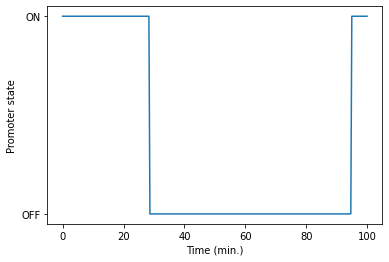

In [3]:
i = np.random.randint(0, nsamples)
fig,ax = plt.subplots(1,1)
ax.plot(ts,samples[i, :])
_= ax.set(xlabel="Time (min.)", ylabel="Promoter state",yticks=[0,1],yticklabels=["OFF","ON"])

The promoter is usually modeled with a constant on and off rate. This seems natural if one does not have extra information and is just observing the gene at a random point in time. However, we seek to drive this model with enhancer-promoter contacts and thus require a time-varying on-rate. As an example, we shall take a toy-model of the on-rate where the on-rate goes up in distinct bursts for a short amount of time:

[Text(0.5, 0, 'Time (s)'), Text(0, 0.5, '$k_\\mathrm{on}$ ($s^{-1}$)')]

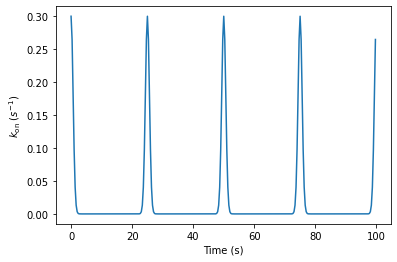

In [4]:
contact_duration = 2*dt
contact_times = jnp.array([0,ntimesteps/4,ntimesteps*2/4,ntimesteps*3/4,ntimesteps])*dt
ts_on = np.arange(ntimesteps)*dt
k_on_drive_timevary = 20*k_on*(1/jnp.sqrt(2*jnp.pi*contact_duration**2))*jnp.exp(-(ts_on[:,None]-contact_times[None,:])**2/(2*contact_duration**2)).sum(axis=1)
fig,ax = plt.subplots(1,1)
ax.plot(ts_on,k_on_drive_timevary)
ax.set(xlabel="Time (s)", ylabel=r"$k_\mathrm{on}$ ($s^{-1}$)")

The sample generator allows us to input a varying on-rate to drive the promoter. The end result is a delayed activation of the gene after the enhancer-promoter contact. To see the average behaviour crisply, we shall average over many trajectories which isn't a problem since the code is running on the GPU. The average behaviour is shown below:

In [5]:
nsamples_here = 10000
samples = cpHMM.Generate_sample(
    k_on_drive_timevary,
    k_off,
    initial_probabilities,
    nsamples_here,
    nstates,
    dt,
    verbose=True,
)

100%|██████████| 300/300 [00:00<00:00, 326.21it/s]


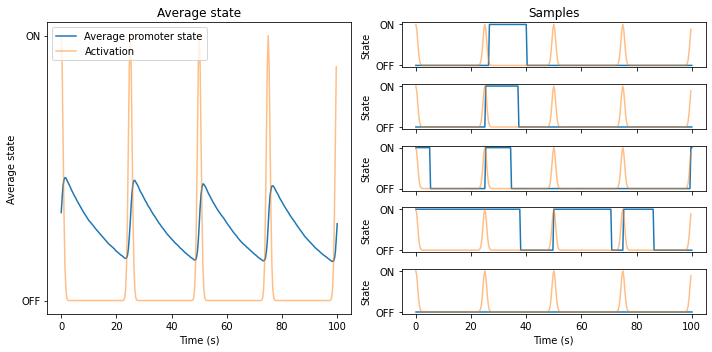

In [6]:
fig = plt.figure(figsize=(10,5))
subplot = fig.add_subplot(121)
sample_axs = [fig.add_subplot(5,2,2+i*2) for i in range(5)]
subplot.plot(ts,samples.mean(axis=0),label="Average promoter state")
subplot.plot(ts_on,k_on_drive_timevary/np.max(k_on_drive_timevary),color="C1",label=r"Activation",alpha=0.5)
subplot.legend(loc="upper left")
subplot.set(xlabel="Time (s)", ylabel=r"Average state",yticks=[0,1],yticklabels=["OFF","ON"],title="Average state")
for i in range(5):
    sample_axs[i].plot(ts,samples[i,:])
    if i ==0:
        sample_axs[i].set(title="Samples")
    if i != 4:
        sample_axs[i].set(ylabel="State",yticks=[0,1],yticklabels=["OFF","ON"],xticklabels=[])
    else:
        sample_axs[i].set(xlabel="Time (s)", ylabel="State",yticks=[0,1],yticklabels=["OFF","ON"])
    sample_axs[i].plot(ts_on,k_on_drive_timevary/np.max(k_on_drive_timevary),alpha=0.5,color="C1",label=r"$k_\mathrm{on}$")
fig.tight_layout()

## Modeling the MS2 measurement process

The promoter state specifies the polymerase loading rate. Ideally, we would want to measure the loading rate directly in real time, however this is not really possible. Instead, people measure the amount of polymerase on the gene using a so-called MS2-array. 

The method relies on the introduction of several sequences of DNA at the start of the gene which each encodes a small RNA sequence which folds into a hairpin once transcribed. The hairpins are recognized by a fluorescent protein which binds to the hairpin and emits a fluorescent signal allowing detection with fluorescent microscopy. Since the hairpins stick around until the polymerase has transcribed the rest of the gene, the fluorescence signal seen from a single loaded polymerase would first increase at a rate given by the transcription speed as it transcribes through the MS2 array. Upon reaching the original gene, the intensity plateaus as the MS2 hairpins are still attached to the RNA coming out of the polymerase. Upon reaching the end of the gene and releasing the transcript, the intensity will drop quickly as the RNA molecule moves away from the region we observe intensity from.

A reasonable model for the intensity from a single polymerase is therefore something like this:

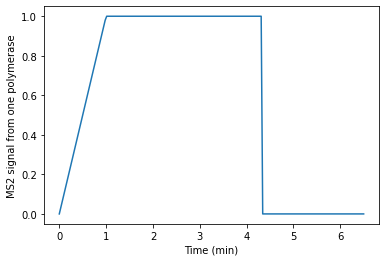

In [7]:
gene_length = 6000 # bp
MS2_size = 2000 # bp
transcription_speed = 30*60 # bp/min
tau = int(round(MS2_size/transcription_speed/dt))
window_size = int(round((MS2_size+gene_length)/transcription_speed/dt))

frames = np.linspace(0,window_size*1.5,200)

fig,ax = plt.subplots(1,1)
ax.plot(frames*dt,cpHMM.MS2_kernel(frames,tau,window_size))
_ = ax.set(xlabel="Time (min)",ylabel="MS2 signal from one polymerase")

Given many polymerase loading events, the intensity at timepoint $n$ will be the weighted sum of the signal from loaded polymerases in the past
$$
I_k = \sum_{i=1}^k n_{k-i}w_i,
$$
where $w_n$ is the time-reverse of the kernel just plotted above and $n_k$ are the number of loaded polymerases loaded in frame $k$. Furthermore, we do not observe the intensity directly but rather a noisy version of it. We shall model the noise as a Gaussian with a standard deviation of $\sigma$ such that the observed intensity is
$$
I_k^\mathrm{obs} = I_k + \epsilon,
$$
where $\epsilon$ is a random variable drawn from a Gaussian distribution with standard deviation $\sigma$.

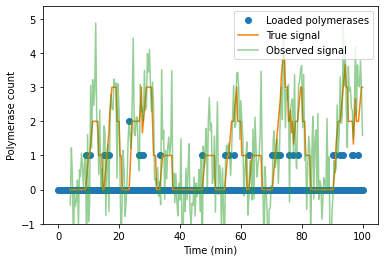

In [8]:
n_loadings = ntimesteps//10
measurement_error = 1

loading_times = np.random.choice(np.arange(0,ntimesteps+1),size=n_loadings,replace=True)
loading_amounts = np.zeros(ntimesteps+1)
for lt in loading_times:
    loading_amounts[lt] +=1
    
signal = cpHMM.conv_func(loading_amounts, cpHMM.MS2_kernel(jnp.arange(window_size), tau, window_size))
signal_w_noise = signal + np.random.normal(0,measurement_error,len(signal))

fig,ax = plt.subplots(1,1)
ax.plot(ts,loading_amounts,"o",label=r"Loaded polymerases")
ax.plot(ts[window_size-1:],signal,label=r"True signal")
ax.plot(ts[window_size-1:],signal_w_noise,label=r"Observed signal",alpha=0.5)
ax.set(xlabel="Time (min)",ylabel="Polymerase count",ylim=(-1,np.max(signal_w_noise)*1.1))
_ = ax.legend(loc="upper right")

Going back to the promoter model, we can now simulate the MS2 data by first simulating the promoter state and then simulating the MS2 data given the promoter state. For the example from before, with time-varying on-rate, the MS2 data would look like this:

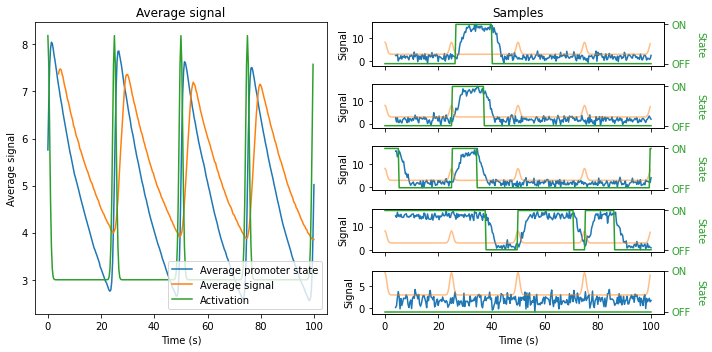

In [9]:

loading_numbers = np.array([0.5, 4]) # polymerases/frame
sampled_rates = cpHMM.swap_inds_for_rates(samples,loading_numbers)
pol2_traj,MS2_traj = cpHMM.Gen_MS2_measurement(sampled_rates,(window_size,tau,measurement_error),dt)

fig = plt.figure(figsize=(10,5))
subplot = fig.add_subplot(121)
sample_axs = [fig.add_subplot(5,2,2+i*2) for i in range(5)]
subplot.plot(ts,samples.mean(axis=0)*np.max(loading_numbers)*window_size*dt,label="Average promoter state")
subplot.plot(MS2_traj[0],MS2_traj[-1].mean(axis=0),label="Average signal")
subplot.plot(ts_on,k_on_drive_timevary*np.max(loading_numbers)*window_size*dt+3,label=r"Activation")
subplot.legend(loc="lower right")
subplot.set(xlabel="Time (s)", ylabel=r"Average signal",title="Average signal")
for i in range(5):
    sample_axs[i].plot(MS2_traj[0],MS2_traj[-1][i,:])
    tx = sample_axs[i].twinx()
    tx.plot(ts,samples[i,:],color="C2")
    if i ==0:
        sample_axs[i].set(title="Samples")
    if i != 4:
        sample_axs[i].set(ylabel="Signal",xticklabels=[])
    else:
        sample_axs[i].set(xlabel="Time (s)", ylabel="Signal")
    tx.set(yticks=[0,1],yticklabels=["OFF","ON"])
    # set the color of ticks and labels to red
    [t.set_color("C2") for t in tx.get_yticklabels()]
    tx.set_ylabel("State",rotation=-90,labelpad=15,color="C2")
    sample_axs[i].plot(ts_on,k_on_drive_timevary*np.max(loading_numbers)*window_size*dt+3,alpha=0.5,color="C1",label=r"$k_\mathrm{on}$")
fig.tight_layout()

Perhaps you can appreciate the difficulty in identifying a signal driving a promoter state from MS2 measurements. Not only is the driving signal stochastically transformed by the promoter state dynamics, we also observe the promoter state only indirectly through the convolution and measurement noise of the MS2 array. This is the problem we shall attempt to solve with the compound state Hidden Markov Model.

## cpHMM 

In general, the inference problem is made difficult by the fact that the MS2 data is non-markovian due to the convolution process of the array. The signal at time $t$ depends not only on the number of polymerases loaded in the immediate past, but instead will depend on all polymerases loaded in the time it would take a polymerase to go through the gene+array. 

There are several ways to approach this problem. A quite accurate method would be to explicitly keep track of polymerases. This was done in a quite coarse-grained fashion by [Corrigan et al. 2016](https://elifesciences.org/articles/13051) and later improved by [Wildner et al. 2023](https://www.biorxiv.org/content/10.1101/2023.06.20.545522v1). We shall take a simpler approach introduce by [Lammers et al. 2019](https://www.pnas.org/doi/full/10.1073/pnas.1912500117) where we only keep track of the past promoter states and assume that they deterministically lead to signal (which is an approximation since loading and translocation is random). Either of these approaches converts the model back to a Markovian model, but at the cost of introducing ever increasing state-space depending on how coarse-grained the model. 

We follow Lammers et al. in calling the promoter state in the last $w$ frames a compund state. For an $n$-state promoter model, the state space is then $n^w$. For the examples above, we would have a statespace of 

In [10]:
print(f"Time interval between frames: {dt} min")
print(f"Time for the polymerase to transcribe the gene+loop: {window_size*dt} min")
print(f"Number of promoter states: {nstates}")
print(f"Number of states to keep track of in the past: {window_size}")
print(f"Compound state space size: {2**window_size}")

Time interval between frames: 0.3333333333333333 min
Time for the polymerase to transcribe the gene+loop: 4.333333333333333 min
Number of promoter states: 2
Number of states to keep track of in the past: 13
Compound state space size: 8192


While this is a large state-space, it is still manageable. Howevewr, the space would quickly grow if the promoter model was more complex or the MS2 array was longer.

To do inference, we need to know how the compound state propagates in time. Since it is just a re-statement of the initial promoter model, we expect the compound state propagation to follow from the promoter model. Ultimately it comes down to a set of allowed transitions and appropriate use of the promoter model transition matrix. First, we require the transition probability matrix of the promoter model which is obtained by taking the matrix exponential of the transition rate matrix $T$:
$$
M_{ij} = \exp(T\Delta t)_{ij}.
$$
The intuition here is that the matrix element $M_{ij}$ is the probability that the state $j$ transitioned to the state $i$ in the time interval $\Delta t$. The propagation of the compund state can be broken into two parts:
1. Deterministic propagation by shifting the entries of the state left by one.
2. State transitions of the second to last state in state $j$ to the last state in state $i$ with probability $M_{ij}$.
The first step leaves the last state unspecified, and the second step gives a probabilistic rule for computing it. 

As an example, consider the state (1,0,1) of a two-state model with $w=3$. The deterministic step would propagate this to 
$$
(1,0,1)\to(0,1,?).
$$
and the second step would give the probability of the last state being 0 or 1:
$$
(1,0,1)\to (0,1,0) \quad \text{with probability } M_{01} \quad \text{or} \quad (1,0,1)\to (0,1,1) \quad \text{with probability } M_{11}.
$$

Putting all this together, the transition probability matrix of the compound state can be written as 
$$
\bra {s'_1,s'_2,\ldots,s'_n} M^\mathrm{cp}\ket{s_1,s_2,\ldots,s_n} = \begin{cases}
M_{s'_n s_{n}} & \text{if } s'_1 = s_2, \ldots, s'_{n-1} = s_n\\
0 & \text{otherwise}.
\end{cases}
$$

Given this, the transition probability matrix for the constant loading rate example would look like this:

In [11]:
T = cpHMM.get_transition_matrix(nstates, k_on, k_off)
M = jsp.linalg.expm(T*dt)
M_cp = cpHMM.get_cp_transition_matrix(M, window_size, verbose=True)

100%|██████████| 8192/8192 [00:06<00:00, 1327.04it/s]


[Text(0.5, 0, 'Current state'), Text(0, 0.5, 'Previous state')]

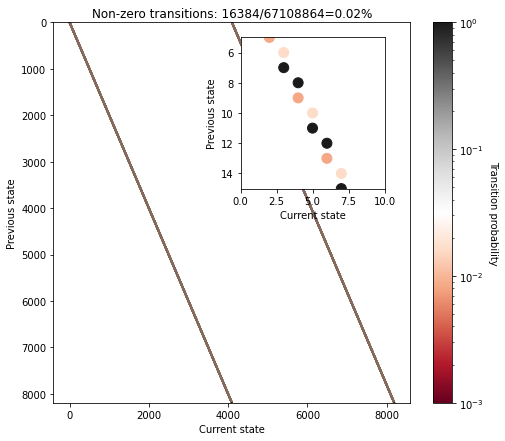

In [52]:
from matplotlib.colors import LogNorm
dense_M_cp = M_cp.todense()
v_grab = jax.vmap(lambda i,j:dense_M_cp[i,j],(0,0))
nonzeros = jnp.argwhere(dense_M_cp)
values = v_grab(nonzeros[:,0],nonzeros[:,1]) 

fig,ax = plt.subplots(1,1,figsize=(8,7))
ax.scatter(nonzeros[:,1],nonzeros[:,0],s=1,c=values,cmap="RdGy",norm=LogNorm(vmin=1e-3,vmax=1))
ax.set(xlabel="Current state",ylabel="Previous state",title=f"Non-zero transitions: {len(nonzeros)}/{len(M_cp)**2}={100*len(nonzeros)/len(M_cp)**2:4.2f}%",ylim=(2**window_size,0))
# create colorbar 
cbar = fig.colorbar(ax.collections[0], ax=ax)
cbar.set_label("Transition probability", rotation=270,labelpad=15)
# create zoomed in inset of the upper left corner
ax_inset = fig.add_axes([0.45,0.55,0.25,0.3])
ax_inset.scatter(nonzeros[:,1],nonzeros[:,0],s=100,c=values,cmap="RdGy",norm=LogNorm(vmin=1e-3,vmax=1))
ax_inset.set(xlim=(0,10),ylim=(15,5))
ax_inset.set(xlabel="Current state",ylabel="Previous state")


With the propagator at hand, the only thing we need is the probability of observing a given MS2 signal given the compound state. Since we know the signal is a weighted sum of the past states, we can simply list out all the states and compute their corresponding signals. Here it becomes important to have a consistent way of numbering the states. The python function itertools.product is useful for this and allows for a simple mapping

In [55]:
state_mapping, sequences = cpHMM.Generate_state_map(nstates,window_size)
for i,s in enumerate(sequences):
    if i<10:
        print(f"State {i}: {s}")

State 0: [0 0 0 0 0 0 0 0 0 0 0 0 0]
State 1: [0 0 0 0 0 0 0 0 0 0 0 0 1]
State 2: [0 0 0 0 0 0 0 0 0 0 0 1 0]
State 3: [0 0 0 0 0 0 0 0 0 0 0 1 1]
State 4: [0 0 0 0 0 0 0 0 0 0 1 0 0]
State 5: [0 0 0 0 0 0 0 0 0 0 1 0 1]
State 6: [0 0 0 0 0 0 0 0 0 0 1 1 0]
State 7: [0 0 0 0 0 0 0 0 0 0 1 1 1]
State 8: [0 0 0 0 0 0 0 0 0 1 0 0 0]
State 9: [0 0 0 0 0 0 0 0 0 1 0 0 1]


Each state will have a number of polymerases it loads per frame, and the signal will be the sum of those polymerases weighted by the kernel.

In [67]:
numbers_loaded = cpHMM.swap_inds_for_rates(samples,loading_numbers)
state_signals = cpHMM.Get_emission_means(sequences,loading_numbers,window_size,tau,dt)
print(f"State loading numbers: {loading_numbers}")
print(f"Weighting function: [{''.join([f'{i:4.2f},' for i in cpHMM.MS2_kernel(np.arange(window_size),tau,window_size)])}]")
for i,s in enumerate(sequences):
    if i<10:
        print(f"State {i}: {s} -> {state_signals[i]:4.2f}")

State loading numbers: [0.5 4. ]
Weighting function: [0.00,0.33,0.67,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,]
State 0: [0 0 0 0 0 0 0 0 0 0 0 0 0] -> 1.83
State 1: [0 0 0 0 0 0 0 0 0 0 0 0 1] -> 1.83
State 2: [0 0 0 0 0 0 0 0 0 0 0 1 0] -> 2.22
State 3: [0 0 0 0 0 0 0 0 0 0 0 1 1] -> 2.22
State 4: [0 0 0 0 0 0 0 0 0 0 1 0 0] -> 2.61
State 5: [0 0 0 0 0 0 0 0 0 0 1 0 1] -> 2.61
State 6: [0 0 0 0 0 0 0 0 0 0 1 1 0] -> 3.00
State 7: [0 0 0 0 0 0 0 0 0 0 1 1 1] -> 3.00
State 8: [0 0 0 0 0 0 0 0 0 1 0 0 0] -> 3.00
State 9: [0 0 0 0 0 0 0 0 0 1 0 0 1] -> 3.00


At this point one can choose several models for how this inherent MS2 intensity is measured, but in our setting we shall employ a Gaussian.

## cpHMM inference